In [2]:
import numpy as np
import torch
import matplotlib.pyplot as plt
import math
from torch import nn
from scipy.fftpack import fft
from tqdm import tqdm
from itertools import chain

torch.manual_seed(42)

In [64]:
class Butterfly(nn.Module):
    def __init__(self, n_points):
        super(Butterfly, self).__init__()
        self.n = n_points
        self.w_left = nn.Conv1d(n_points, n_points//2, 1)
        self.w_right = nn.Conv1d(n_points, n_points//2, 1)
    
    def forward(self, x):
        return torch.cat([self.w_left(x), self.w_right(x)], dim=0)

class Model(nn.Module):
    def __init__(self, n_points):
        super(Model, self).__init__()
        order_bitwidth = int(math.log(n_points)/math.log(2))
        self.order = [int('{:0{width}b}'.format(n, width=order_bitwidth)[::-1], 2) for n in range(0, n_points)]
        butter = []
        while n_points > 1:
            butter += [Butterfly(n_points)]
            n_points //= 2
        self.butter = nn.Sequential(*butter)
    
    def forward(self, x):
        batch_size = x.size(0)
        y = self.butter(x).split(batch_size, dim=0)
        return torch.cat([y[o] for o in self.order], dim=1)

In [65]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
batch_size = int(1e3)
n_points = 16

model = Model(n_points).to(device)
criterion = nn.SmoothL1Loss(reduction='sum')
optimizer = torch.optim.Adam(model.parameters(), lr=1e-4)

epochs = int(5e4)
print_time = epochs // 10

In [ ]:
for epoch in tqdm(range(epochs), "IDFTing", position=0):
    # Generating inputs/outputs
    y = np.random.rand(batch_size, n_points)
    x = fft(y)

    # Preparing for pytorch
    x_r = torch.tensor(x.real).view(batch_size, -1, 1).float().to(device)
    x_j = torch.tensor(x.imag).view(batch_size, -1, 1).float().to(device)
    y = torch.tensor(y).float().to(device)

    # Calculating IDFT
    y_predr = model(x_r).squeeze()
    y_predj = model(x_j).squeeze()
    y_pred = (y_predr + y_predj)

    # Optimizing
    optimizer.zero_grad()
    loss = criterion(y_pred, y)
    loss.backward()
    optimizer.step()

    # Logging
    if epoch % print_time == 0:
        tqdm.write(f"{epoch}:: {loss.item()}")

IDFTing:   0%|          | 29/50000 [00:00<06:40, 124.88it/s]s]]

0:: 6163.3525390625


IDFTing:  10%|█         | 5022/50000 [00:29<04:30, 166.37it/s]]

5000:: 209.61289978027344


IDFTing:  20%|██        | 10032/50000 [00:58<04:00, 166.34it/s]

10000:: 0.3695630431175232


IDFTing:  30%|███       | 15020/50000 [01:27<03:34, 163.11it/s]

15000:: 0.00039386749267578125


IDFTing:  40%|████      | 20029/50000 [01:57<03:01, 164.83it/s]

20000:: 1.2968632290721871e-05


IDFTing:  50%|█████     | 25018/50000 [02:25<02:30, 165.57it/s]

25000:: 5.952751962468028e-06


IDFTing:  60%|██████    | 30032/50000 [02:54<01:58, 169.12it/s]

30000:: 6.732047950208653e-07


IDFTing:  70%|███████   | 35025/50000 [03:24<01:30, 164.72it/s]

35000:: 9.554023563396186e-07


IDFTing:  74%|███████▍  | 36951/50000 [03:35<01:14, 174.25it/s]

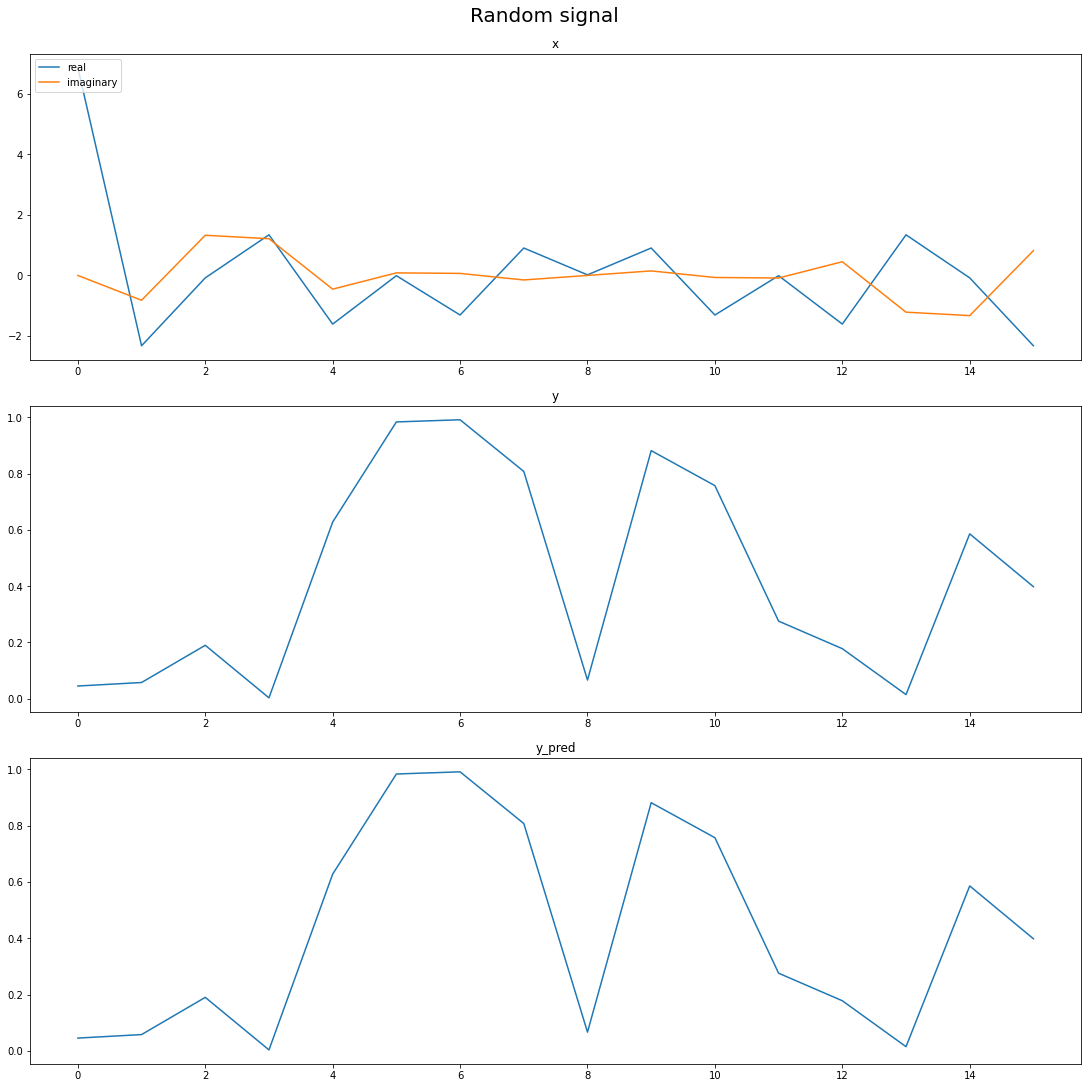

In [34]:
y = np.random.rand(1, n_points)
x = fft(y)
x_r = torch.tensor(x.real).view(1, -1, 1).float().to(device)
x_j = torch.tensor(x.imag).view(1, -1, 1).float().to(device)
with torch.no_grad():
    y_predr = model(x_r).squeeze()
    y_predj = model(x_j).squeeze()
    y_pred = (y_predr + y_predj).cpu().numpy()
fig, ax = plt.subplots(3, figsize=(15, 15), constrained_layout=True)
ax[0].plot(x[0].real, label='real')
ax[0].plot(x[0].imag, label='imaginary')
ax[0].set_title("x")
ax[0].legend(loc="upper left")
ax[1].plot(y[0])
ax[1].set_title("y")
ax[2].plot(y_pred)
ax[2].set_title("y_pred")
fig.suptitle("Random signal", fontsize=20)
fig.show()

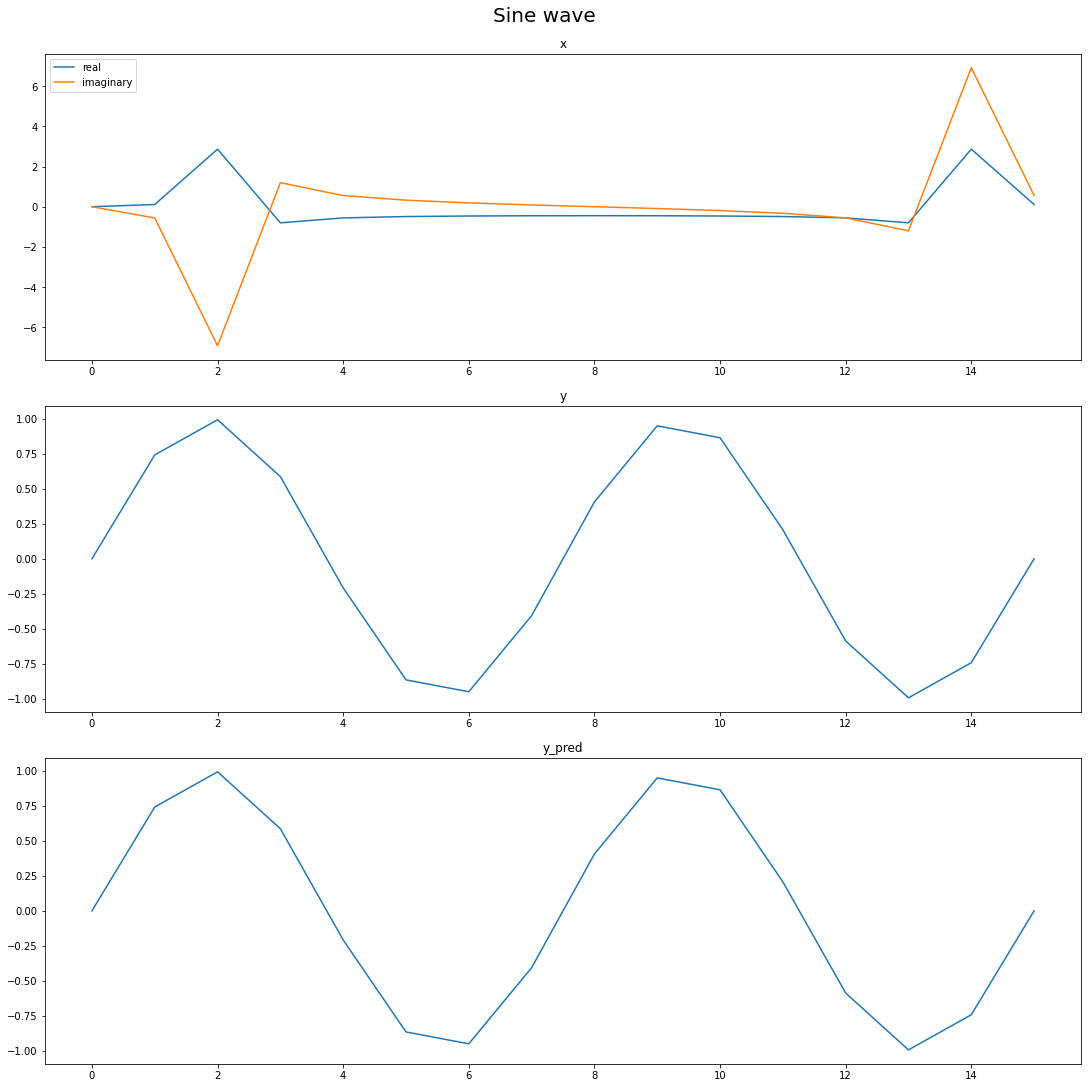

In [35]:
y = np.sin(np.linspace(-2*np.pi, 2*np.pi, n_points))
x = fft(y)
x_r = torch.tensor(x.real).view(1, -1, 1).float().to(device)
x_j = torch.tensor(x.imag).view(1, -1, 1).float().to(device)
with torch.no_grad():
    y_predr = model(x_r).squeeze()
    y_predj = model(x_j).squeeze()
    y_pred = (y_predr + y_predj).cpu().numpy()
fig, ax = plt.subplots(3, figsize=(15, 15), constrained_layout=True)
ax[0].plot(x.real, label='real')
ax[0].plot(x.imag, label='imaginary')
ax[0].set_title("x")
ax[0].legend(loc="upper left")
ax[1].plot(y)
ax[1].set_title("y")
ax[2].plot(y_pred)
ax[2].set_title("y_pred")
fig.suptitle("Sine wave", fontsize=20)
fig.show()